In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions import *

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

In [ ]:
## Acknowledgement: many important pieces of code in this notwbook were taken from the following video:
## https://www.youtube.com/watch?v=S8tpSG6Q2H0

In [2]:
data = pd.read_csv('../data/daily_prices_historical.csv')
data.head()

,date,value
0,1973-08-20,0.6735
1,1973-08-21,0.6710
2,1973-08-22,0.6580
3,1973-08-23,0.6675
4,1973-08-24,0.6660


In [3]:
# saving the index of where the last year in the data begins (last year --> 2020-08-10 - 2021-08-10)
last_year_start_index = data[data['date']=='2020-08-10'].index[0]
last_year_start_index

11770

In [4]:
# set 'date' column as index
data.set_index(pd.DatetimeIndex(data['date']), inplace=True)

In [5]:
# sort index
data.sort_index(inplace=True)

In [6]:
# drop index column
data.drop(columns='date',inplace=True)

In [7]:
# check the data
data.head(), data.tail()

(             value
 date              
 1973-08-20  0.6735
 1973-08-21  0.6710
 1973-08-22  0.6580
 1973-08-23  0.6675
 1973-08-24  0.6660,
              value
 date              
 2021-08-04  1.7565
 2021-08-05  1.7690
 2021-08-06  1.7600
 2021-08-09  1.7935
 2021-08-10  1.8200)

In [8]:
# train-test split
train = data.iloc[:last_year_start_index]
test = data.iloc[last_year_start_index:] # the last year in the data, from 2020-08-10 to 2021-08-10

In [9]:
print(train.shape)
print(test.shape) # we only have 259 data points for 2021, because there are some days without data

(11770, 1)
(259, 1)


In [10]:
# splitting the train data into train and validation to pass into the model
train, validation = train_test_split(train, shuffle=False, train_size=0.85, random_state=123)

In [11]:
print(train.shape)
print(validation.shape)

(10004, 1)
(1766, 1)


In [12]:
# scaling the data
sc = MinMaxScaler()
sc.fit(train)

train_sc = sc.transform(train)
validation_sc = sc.transform(validation)
test_sc = sc.transform(test)

In [13]:
train_sc

array([[0.08477467],
       [0.08392181],
       [0.07948692],
       ...,
       [0.27342817],
       [0.27069901],
       [0.26609354]])

In [14]:
validation_sc[:5]

array([[0.26182922],
       [0.24715996],
       [0.24221335],
       [0.24118992],
       [0.2406782 ]])

In [15]:
test_sc[:5]

array([[0.23914304],
       [0.23487872],
       [0.23726674],
       [0.25142428],
       [0.2463071 ]])

In [16]:
# parameters for TimeseriesGenerator
n_input = 10
n_features = 1

In [17]:
train_generator = TimeseriesGenerator(train_sc, train_sc, length=n_input, batch_size=1)
validation_generator = TimeseriesGenerator(validation_sc, validation_sc, length=n_input, batch_size=1)

In [18]:
# looking at the first batch of train data and the to-be predicted value
X_train, y_train = train_generator[0]
print(f'Given the array \n{X_train.flatten()}\n')
print(f'Predict this y: \n{y_train}')

Given the array 
[0.08477467 0.08392181 0.07948692 0.0827278  0.08221608 0.07982806
 0.0733463  0.07147    0.07290281 0.07341453]

Predict this y: 
[[0.07443796]]


In [19]:
# looking at the first batch of validation data and the to-be predicted value
X_val, y_val = validation_generator[0]
print(f'Given the array \n{X_val.flatten()}\n')
print(f'Predict this y: \n{y_val}')

Given the array 
[0.26182922 0.24715996 0.24221335 0.24118992 0.2406782  0.24408965
 0.24347559 0.2512196  0.25023027 0.24889981]

Predict this y: 
[[0.25483574]]


In [20]:
# checking the data shapes
X_train.shape

(1, 10, 1)

In [21]:
X_val.shape

(1, 10, 1)

In [22]:
test_sc.shape

(259, 1)

In [23]:
# instantiate the model
model = Sequential()

In [24]:
# adding layers
model.add(GRU(100, input_shape = (n_input, n_features), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(50, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))

model.add(Dense(1))

In [25]:
# compile the model
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10, 100)           30900     
_________________________________________________________________
dropout (Dropout)            (None, 10, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 54,221
Trainable params: 54,221
Non-trainable params: 0
____________________________________________________

In [27]:
# defining early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          restore_best_weights = True)

In [28]:
# fit the model
history = model.fit(train_generator, epochs=30, verbose=1, validation_data=validation_generator,
                    callbacks=[earlystop])

Epoch 1/30
9994/9994 [==============================] - 96s 9ms/step - loss: 0.0013 - val_loss: 2.9012e-04
Epoch 2/30
9994/9994 [==============================] - 90s 9ms/step - loss: 7.1634e-04 - val_loss: 2.6319e-04
Epoch 3/30
9994/9994 [==============================] - 68s 7ms/step - loss: 6.2816e-04 - val_loss: 3.9690e-04
Epoch 4/30
9994/9994 [==============================] - 65s 7ms/step - loss: 5.4550e-04 - val_loss: 1.6756e-04
Epoch 5/30
9994/9994 [==============================] - 67s 7ms/step - loss: 4.9916e-04 - val_loss: 2.4441e-04
Epoch 6/30
9994/9994 [==============================] - 72s 7ms/step - loss: 4.8300e-04 - val_loss: 1.3457e-04
Epoch 7/30
9994/9994 [==============================] - 97s 10ms/step - loss: 4.7471e-04 - val_loss: 1.2998e-04
Epoch 8/30
9994/9994 [==============================] - 101s 10ms/step - loss: 4.4135e-04 - val_loss: 2.6587e-04
Epoch 9/30
9994/9994 [==============================] - 116s 12ms/step - loss: 4.3505e-04 - val_loss: 2.5856e-04


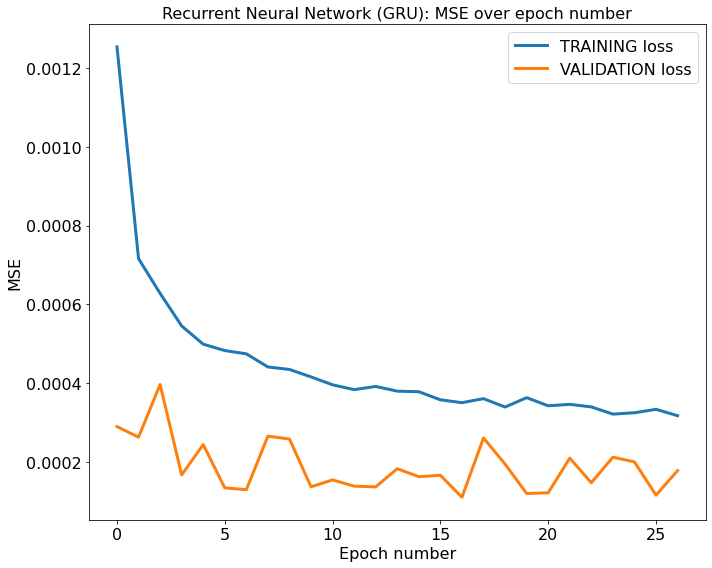

In [29]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='TRAINING loss', color='tab:blue', linewidth=3)
plt.plot(history.history['val_loss'], label='VALIDATION loss', color='tab:orange', linewidth=3)
plt.legend(prop = {'size':16})
plt.title(f'Recurrent Neural Network (GRU): MSE over epoch number', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);
plt.xlabel('Epoch number', fontsize=16)
plt.ylabel('MSE', fontsize=16)
plt.tight_layout();
plt.savefig('../images/plots/RNN/RNN_loss.jpeg')

In [30]:
# check a prediction as an example
# take the last 10 days in the training data 
last_train_batch = train_sc[-10:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [31]:
last_train_batch

array([[[0.2631938 ],
        [0.25722376],
        [0.26796984],
        [0.2713813 ],
        [0.27428104],
        [0.27615734],
        [0.26643469],
        [0.27342817],
        [0.27069901],
        [0.26609354]]])

In [32]:
# generate a prediction on that data - this is the first prediction in the test data
model.predict(last_train_batch)

array([[0.26580638]], dtype=float32)

In [33]:
# check the actual value, to compare to the prediction
test_sc[0]

array([0.23914304])

In [34]:
# generate test predictions - self-made function
test_predictions = generate_predictions(train = train_sc, 
                                        len_test=len(test_sc), 
                                        n_input=10, 
                                        n_features=1, 
                                        model=model # model 
                                       )

In [35]:
# first 5 predictions
test_predictions[:5]

[array([0.26580638], dtype=float32),
 array([0.26629153], dtype=float32),
 array([0.2669898], dtype=float32),
 array([0.26735395], dtype=float32),
 array([0.2683369], dtype=float32)]

In [36]:
# put the predictions in the original scale
test_predictions_rescaled = sc.inverse_transform(test_predictions)

In [37]:
# adding the predictions to the test data frame
test['predictions'] = test_predictions_rescaled

<ipython-input-37-ba447eb94b4f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = test_predictions_rescaled


In [38]:
test

,value,predictions
date,,
2020-08-10,1.1260,1.204158
2020-08-11,1.1135,1.205580
2020-08-12,1.1205,1.207627
2020-08-13,1.1620,1.208695
2020-08-14,1.1470,1.211576
...,...,...
2021-08-04,1.7565,1.232729
2021-08-05,1.7690,1.232729
2021-08-06,1.7600,1.232729


In [39]:
# titles for plot
x_label = 'Date'
y_label = 'Price in USD / lb of green coffee'
plot_title = 'Recurrent Neural Network (GRU):\nActual & Predicted prices in the test data (last 365 days)'

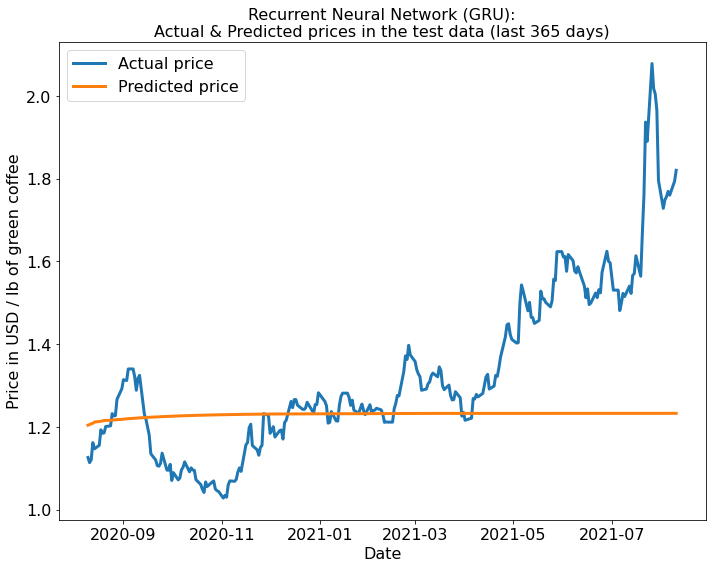

In [46]:
test_fig = plot_test_predictions(test_df = test, x_label=x_label, y_label=y_label, plot_title=plot_title)

test_fig.savefig('../images/plots/RNN/RNN_test_predictions.jpeg')

In [47]:
# calculate MSE
mean_squared_error(test['value'], test['predictions'])

0.05072939454031454

In [48]:
mape(test['value'], test['predictions'])

10.812331275396904

In [49]:
# save the model
model.save('../models/RNN')

INFO:tensorflow:Assets written to: ../models/RNN\assets


INFO:tensorflow:Assets written to: ../models/RNN\assets


---

### Calculating training set predictions

In [52]:
# check one prediction as an example
# take the first 10 days in the training data 
first_train_batch = train_sc[:10]
first_train_batch = first_train_batch.reshape((1, n_input, n_features))

In [53]:
first_train_batch

array([[[0.08477467],
        [0.08392181],
        [0.07948692],
        [0.0827278 ],
        [0.08221608],
        [0.07982806],
        [0.0733463 ],
        [0.07147   ],
        [0.07290281],
        [0.07341453]]])

In [54]:
# generate a prediction on that data - the first prediction in the train data
model.predict(first_train_batch)

array([[0.06750029]], dtype=float32)

In [55]:
# check the actual value, to compare to the prediction
train_sc[10]

array([0.07443796])

In [82]:
# empty list to be filled with predictions of the test set
train_predictions = []

# taking the first X days in the train data - this will give the first prediction for the training set
first_eval_batch = train_sc[:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# iterating for as long as the length of the train data set
for i in range(len(train_sc)):
    
    print(f'processing iteraion: {i}... ')

    # get the prediction for the first batch
    current_prediction = model.predict(current_batch)[0]

    # append the prediction to the test_predictions list
    train_predictions.append(current_prediction)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis=1)
    
    print('... done.') # This will take long, we have more than 10,000 data points in train_sc

processing iteraion: 0... 
... done.
processing iteraion: 1... 
... done.
processing iteraion: 2... 
... done.
processing iteraion: 3... 
... done.
processing iteraion: 4... 
... done.
processing iteraion: 5... 
... done.
processing iteraion: 6... 
... done.
processing iteraion: 7... 
... done.
processing iteraion: 8... 
... done.
processing iteraion: 9... 
... done.
processing iteraion: 10... 
... done.
processing iteraion: 11... 
... done.
processing iteraion: 12... 
... done.
processing iteraion: 13... 
... done.
processing iteraion: 14... 
... done.
processing iteraion: 15... 
... done.
processing iteraion: 16... 
... done.
processing iteraion: 17... 
... done.
processing iteraion: 18... 
... done.
processing iteraion: 19... 
... done.
processing iteraion: 20... 
... done.
processing iteraion: 21... 
... done.
processing iteraion: 22... 
... done.
processing iteraion: 23... 
... done.
processing iteraion: 24... 
... done.
processing iteraion: 25... 
... done.
processing iteraion: 2

In [88]:
train_predictions_rescaled = sc.inverse_transform(train_predictions)

In [89]:
train['predictions'] = train_predictions_rescaled

In [90]:
train

,value,predictions
date,,
1973-08-20,0.6735,0.622864
1973-08-21,0.6710,0.616869
1973-08-22,0.6580,0.609485
1973-08-23,0.6675,0.601899
1973-08-24,0.6660,0.593817
...,...,...
2013-08-12,1.2345,0.433677
2013-08-13,1.2060,0.433677
2013-08-14,1.2265,0.433677


In [92]:
# titles for plot
x_label = 'Date'
y_label = 'Price in USD / lb of green coffee'
plot_title = 'Recurrent Neural Network (GRU):\nActual & Predicted prices in the training data'

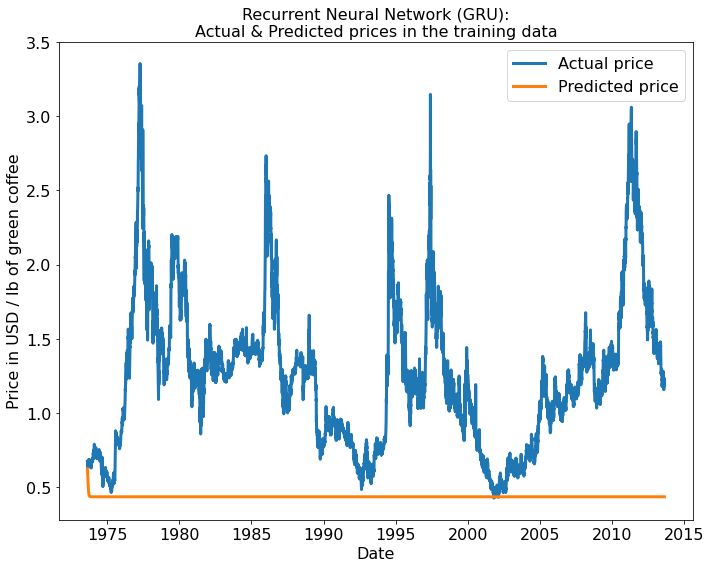

In [93]:
plt.figure(figsize=(10,8))
plt.plot(train['value'], linewidth=3, label='Actual price', color='tab:blue');
plt.plot(train['predictions'], linewidth=3, label='Predicted price', color='tab:orange');
plt.legend(prop = {'size':16})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);
plt.xlabel(x_label, fontsize=16);
plt.ylabel(y_label, fontsize=16)
plt.title(plot_title, fontsize=16);
plt.tight_layout();
plt.show();

In [94]:
# calculate MSE
mean_squared_error(train['value'], train['predictions'])

0.9218786577075505

In [95]:
mape(train['value'], train['predictions'])

59.03267172836644

---